In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d as histo2D
import seaborn as sns
import datetime



In [2]:
path = 'testi.csv'
df = pd.read_csv(path)
df['datetime'] = pd.to_datetime(df['datetime'])

In [3]:
LONG = 25
lats=[57, 66]
lons=[LONG-1, LONG+2]
res=[0.15, 1]

min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

mask = ((df['glon'] >= min_lon) & (df['glon'] <= max_lon) &
                (df['gdlat'] >= min_lat) & (df['gdlat'] <= max_lat))
df = df[mask]

In [4]:
DATETIME = df.iloc[0]['datetime'].date()
frames = df['datetime'].unique()
df0 = df.loc[df['datetime'] == frames[0]]

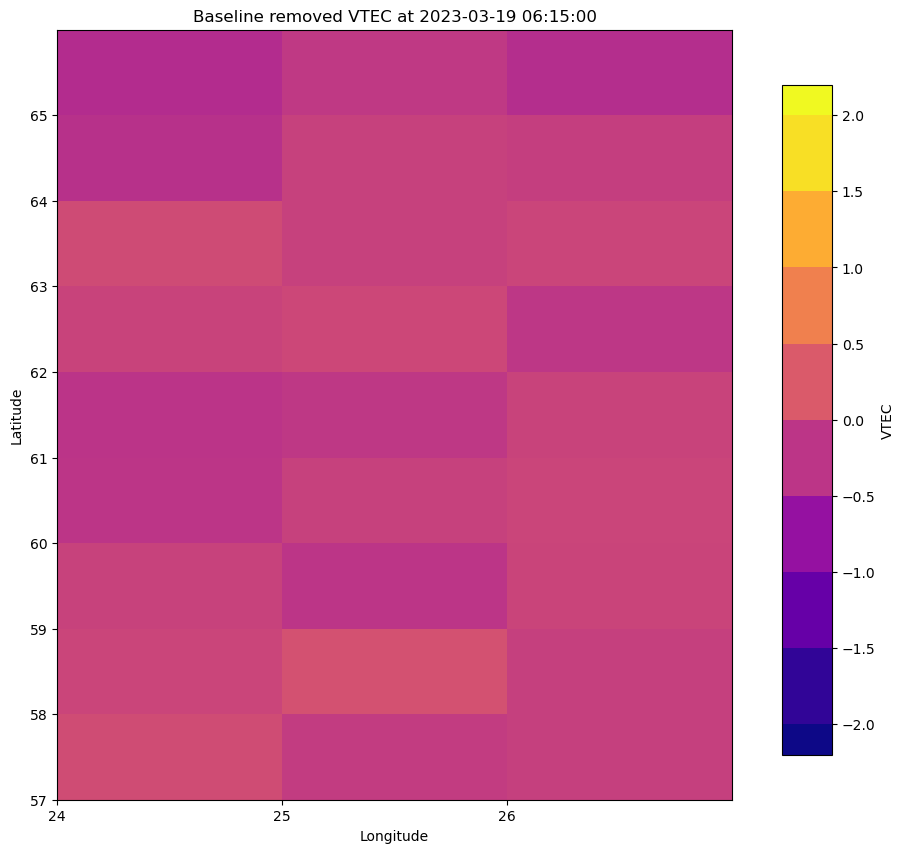

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Baseline removed VTEC at {frames[0]}')
ax.set_xticks(np.arange(lons[0], lons[1], 1))
ax.set_yticks(np.arange(lats[0], lats[1]))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(lons[0], lons[1])
ax.set_ylim(lats[0], lats[1])

statistic, x_edges, y_edges, _ = histo2D(
    df0['glon'], df0['gdlat'], df0['blrmvd'], statistic='mean', 
    bins=[np.arange(lons[0], lons[1] + res[0], res[0]), 
    np.arange(lats[0], lats[1] + res[0], res[0])]) # type: ignore

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = statistic.flatten()

valid = ~np.isnan(z_flat)
x_valid = x_flat[valid]
y_valid = y_flat[valid]
z_valid = z_flat[valid]

statistic, x_edges, y_edges, _ = histo2D(
    x_valid, y_valid, z_valid, statistic='mean', 
    bins=[np.arange(lons[0], lons[1] + res[1], res[1]), 
    np.arange(lats[0], lats[1] + res[1], res[1])]) # type: ignore
X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)


contour = ax.pcolormesh(X, Y, statistic.T, cmap='plasma', vmin=-2, vmax=2)

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',
                            extendrect = True, label='VTEC',
                            ticks=np.arange(-2,2.5,0.5),
                            boundaries = np.arange(-2,2.5,0.5), 
                            extend='both')


C:\Users\virtanem\AppData\Local\Temp\ipykernel_22512\2023875320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['time_seconds'] = (df1['datetime'] - reference_time).dt.total_seconds()


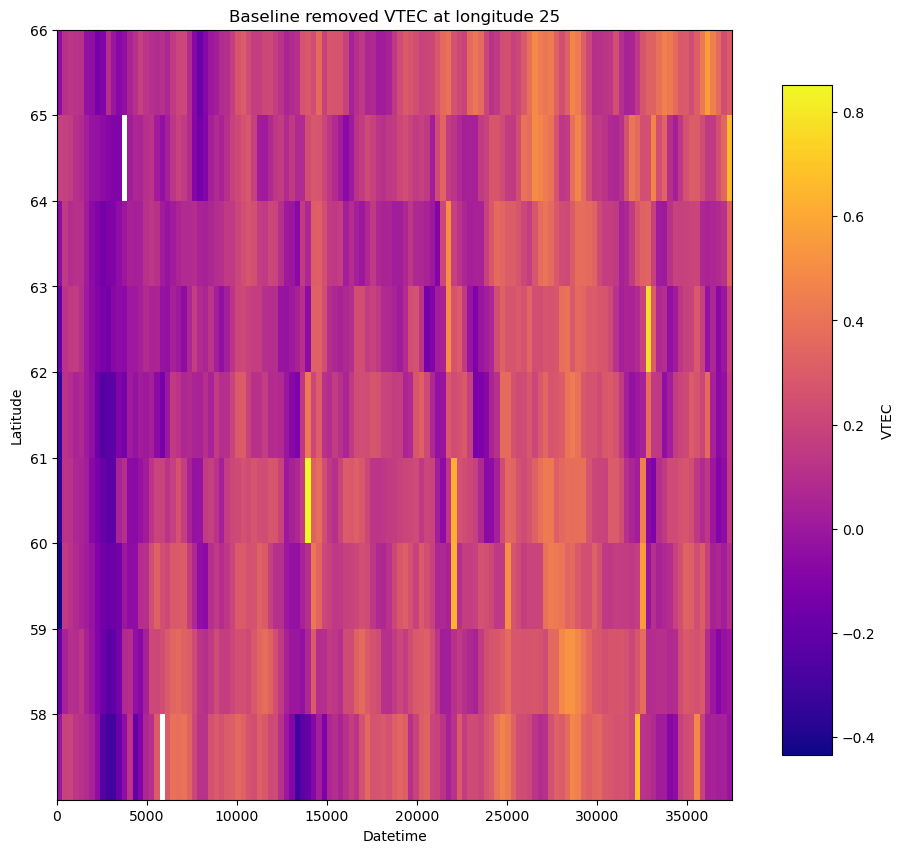

In [6]:
res=[1]

df1 = df.loc[(df['glon'] >= LONG) & (df['glon'] <= LONG+1)]

reference_time = df1['datetime'].min()
df1['time_seconds'] = (df1['datetime'] - reference_time).dt.total_seconds()

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Baseline removed VTEC at longitude {LONG}')
ax.set_ylabel('Latitude')
ax.set_xlabel('Datetime')

# Define bins
time_bin_edges = np.arange(0, df1['time_seconds'].max() + 300, 300)  # 5 minutes in seconds
latitude_bin_edges = np.arange(df1['gdlat'].min(), df1['gdlat'].max() + res[0], res[0])

statistic, x_edges, y_edges, _ = histo2D(
    df1['time_seconds'], df1['gdlat'], df1['blrmvd'], statistic='mean',
    bins=[time_bin_edges, latitude_bin_edges])

X, Y = np.meshgrid((x_edges[:-1] + x_edges[1:]) / 2, (y_edges[:-1] + y_edges[1:]) / 2)

contour = ax.pcolormesh(X, Y, statistic.T, cmap='plasma')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.155, 0.05, 0.67]) # type: ignore

cbar = plt.colorbar(contour, cax=cax, orientation='vertical',label='VTEC')



In [16]:
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = statistic.flatten()

# Create a DataFrame
binned_data_df = pd.DataFrame({
    'time_seconds': x_flat,
    'gdlat': y_flat,
    'blrmvd': z_flat
})

# Optionally, convert time_seconds back to datetime if needed
reference_time = df1['datetime'].min()
binned_data_df['datetime'] = pd.to_timedelta(binned_data_df['time_seconds']-150, unit='s') + reference_time

# Save to CSV
#binned_data_df.to_csv('binned_data.csv', index=False)
binned_data_df

,time_seconds,gdlat,blrmvd,datetime
0,150.0,57.500034,-0.002260,2023-03-19 06:15:00
1,450.0,57.500034,-0.177515,2023-03-19 06:20:00
2,750.0,57.500034,-0.434128,2023-03-19 06:25:00
3,1050.0,57.500034,-0.350627,2023-03-19 06:30:00
4,1350.0,57.500034,-0.341897,2023-03-19 06:35:00
...,...,...,...,...
1120,36150.0,65.500034,0.165148,2023-03-19 16:15:00
1121,36450.0,65.500034,0.193759,2023-03-19 16:20:00
1122,36750.0,65.500034,0.328311,2023-03-19 16:25:00
1123,37050.0,65.500034,0.658830,2023-03-19 16:30:00


C:\Users\virtanem\AppData\Local\Temp\ipykernel_25736\3547289181.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_bins = pd.date_range(start=df2['datetime'].min(), end=df2['datetime'].max(), freq='5T')  # 5-minute bins for datetime
C:\Users\virtanem\AppData\Local\Temp\ipykernel_25736\3547289181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['lat_bin'] = pd.cut(df2['gdlat'], bins=latitude_bins, labels=latitude_bins[:-1])
C:\Users\virtanem\AppData\Local\Temp\ipykernel_25736\3547289181.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

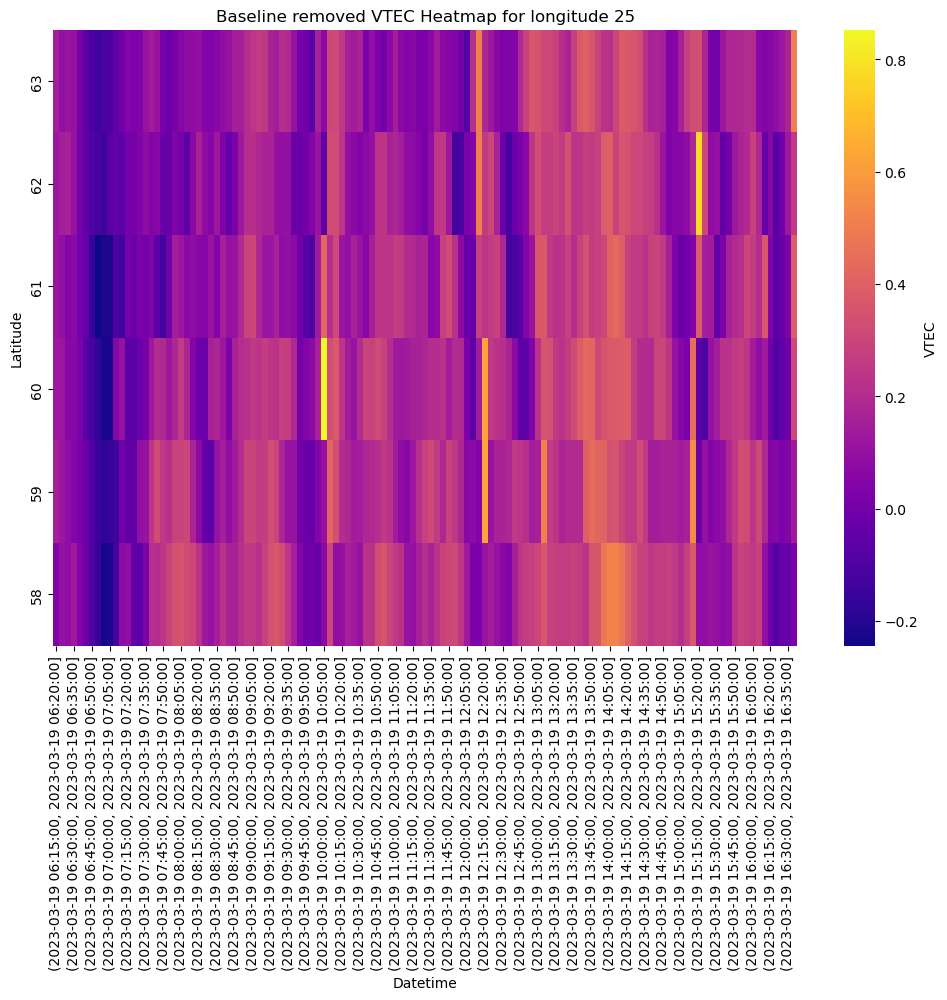

In [ ]:
df2 = df.loc[(df['glon'] >= LONG) & (df['glon'] <= LONG+1)]

# Bin the data
latitude_bins = np.arange(58, 65, 1)  # 1-degree bins for latitude
datetime_bins = pd.date_range(start=df2['datetime'].min(), end=df2['datetime'].max(), freq='5T')  # 5-minute bins for datetime

df2['lat_bin'] = pd.cut(df2['gdlat'], bins=latitude_bins, labels=latitude_bins[:-1])
df2['time_bin'] = pd.cut(df2['datetime'], bins=datetime_bins)

# Aggregate the binned data
binned_data = df2.groupby(['lat_bin', 'time_bin']).blrmvd.mean().unstack()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(binned_data, cmap='plasma', cbar_kws={'label': 'VTEC'})

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'Baseline removed VTEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.xticks(rotation=90)  # Rotate datetime labels for better readability
plt.show()
